Num GPUs Available: 1
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - loss: 0.0636 - val_loss: 0.0359
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260 - val_loss: 0.0131
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123 - val_loss: 0.0104
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 0.0058
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Average PSNR: 22.51 dB


<ipython-input-1-39d79349ce61>:57: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_values = [psnr(x_test[i], restored_images[i]) for i in range(len(x_test[:100]))]


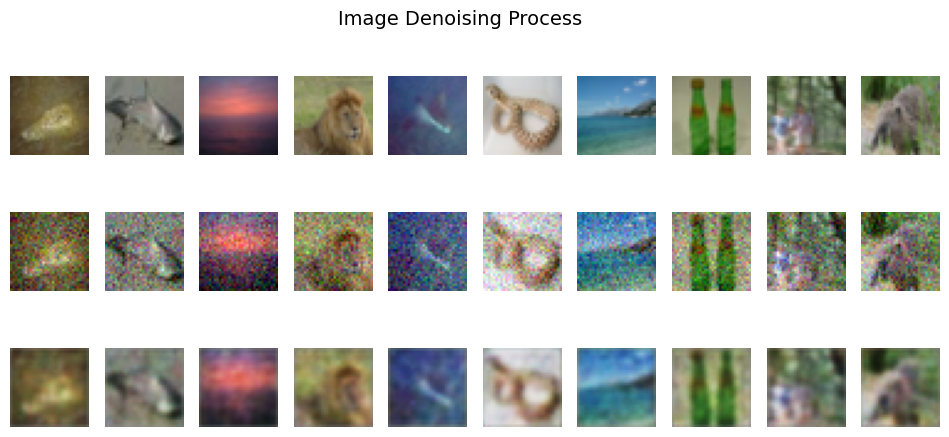

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr

# Enable Mixed Precision Training
mixed_precision.set_global_policy('mixed_float16')

# Load & Preprocess Data
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train[:5000], x_test[:1000]  # Use a smaller dataset for faster training
    return x_train, x_test

# Simulate Degradation
def add_noise(images):
    noisy_images = np.array([random_noise(img, mode='gaussian', var=0.01) for img in images], dtype=np.float32)
    return np.clip(noisy_images, 0, 1)

def build_autoencoder():
    input_img = layers.Input(shape=(32, 32, 3))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Train Model
def train_autoencoder(autoencoder, x_train, x_test):
    noisy_train, noisy_test = add_noise(x_train), add_noise(x_test)

    train_dataset = tf.data.Dataset.from_tensor_slices((noisy_train, x_train)).batch(256).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((noisy_test, x_test)).batch(256).prefetch(tf.data.AUTOTUNE)

    autoencoder.fit(train_dataset, epochs=10, validation_data=test_dataset)  # Increased epochs for better clarity
    return autoencoder, noisy_test

# Evaluate Model
def evaluate_model(autoencoder, x_test, noisy_test):
    restored_images = autoencoder.predict(noisy_test)

    # Ensure correct dtype
    noisy_test = np.clip(noisy_test, 0, 1).astype(np.float32)
    restored_images = np.clip(restored_images, 0, 1).astype(np.float32)

    psnr_values = [psnr(x_test[i], restored_images[i]) for i in range(len(x_test[:100]))]
    print(f'Average PSNR: {np.mean(psnr_values):.2f} dB')

    # Sort by PSNR values to ensure clear images first
    sorted_indices = np.argsort(psnr_values)[::-1]

    # Show original, noisy, and restored images with labels
    fig, axes = plt.subplots(3, 10, figsize=(12, 5))
    fig.suptitle("Image Denoising Process", fontsize=14)
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Noisy", fontsize=12)
    axes[2, 0].set_ylabel("Restored", fontsize=12)

    for i, idx in enumerate(sorted_indices[:10]):
        axes[0, i].imshow(x_test[idx])
        axes[1, i].imshow(noisy_test[idx])
        axes[2, i].imshow(restored_images[idx])
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        axes[2, i].axis('off')
    plt.show()

# Check for GPU availability
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Run the pipeline
x_train, x_test = load_data()
autoencoder = build_autoencoder()
autoencoder, noisy_test = train_autoencoder(autoencoder, x_train, x_test)
evaluate_model(autoencoder, x_test, noisy_test)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.0087 - loss: 4.6086 - val_accuracy: 0.0100 - val_loss: 4.6053
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0086 - loss: 4.6060 - val_accuracy: 0.0100 - val_loss: 4.6053
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0092 - loss: 4.6059 - val_accuracy: 0.0100 - val_loss: 4.6053
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.0093 - loss: 4.6059 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.0088 - loss: 4.6059 - val_accuracy: 0.0100 - val_loss: 4.6052
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.0099 - loss: 4.6173 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.0094 - loss: 4.6059 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━

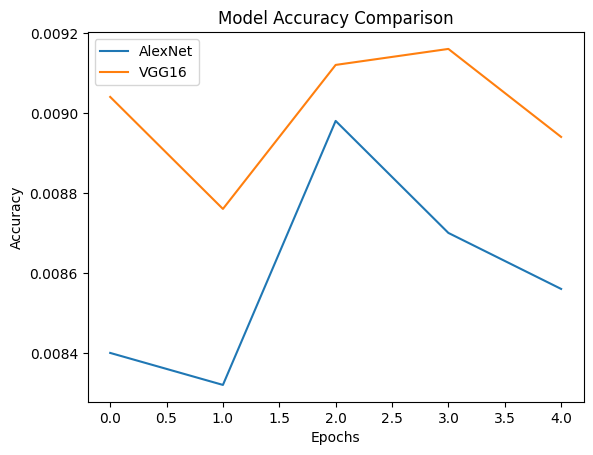

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import time
import matplotlib.pyplot as plt

# Load & Preprocess Data
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

    # Use original 32x32 images to reduce memory usage
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    return x_train, y_train, x_test, y_test

# Define Optimized AlexNet Model
def build_alexnet():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(96, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(100, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Load Pretrained VGG16 Model with Optimization
def build_vgg16():
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(100, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Model
def train_model(model, x_train, y_train, x_test, y_test, epochs=5, batch_size=16):
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=batch_size)
    elapsed_time = time.time() - start_time
    return history, elapsed_time

# Evaluate Model
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return accuracy

# Load Data
x_train, y_train, x_test, y_test = load_data()

# Build and Train AlexNet
alexnet = build_alexnet()
alexnet_history, alexnet_time = train_model(alexnet, x_train, y_train, x_test, y_test)
alexnet_acc = evaluate_model(alexnet, x_test, y_test)
del alexnet  # Free memory

# Build and Train VGG16
vgg16 = build_vgg16()
vgg16_history, vgg16_time = train_model(vgg16, x_train, y_train, x_test, y_test)
vgg16_acc = evaluate_model(vgg16, x_test, y_test)

del vgg16  # Free memory

# Compare Results
print(f"AlexNet Accuracy: {alexnet_acc:.2f}, Training Time: {alexnet_time:.2f}s")
print(f"VGG16 Accuracy: {vgg16_acc:.2f}, Training Time: {vgg16_time:.2f}s")

# Plot Accuracy Comparison
plt.plot(alexnet_history.history['accuracy'], label='AlexNet')
plt.plot(vgg16_history.history['accuracy'], label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.show()